In [1]:
import numpy as np
import keras
import pandas as pd
import json
import imageio
from skimage.transform import resize
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
def load_data(mode):
    if mode == 'TRAIN':
        json_path = '../../data/reference_images_part1.json'
        images_path = '../../data/reference_images_part1/'
    elif mode == 'VAL':
        json_path = '../../data/images_part1_valid.json'
        images_path = '../../data/images_part1_valid/'
    else:
        raise ValueError('usupported mode')
    with open(json_path) as json_data:
        data = json.load(json_data)
    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])
    categories = pd.DataFrame(data['categories'])

    df = pd.DataFrame()

    X = []
    y = []
    y_desc = []
    occluded = []
    bboxes = []
    im_ids = []

    for instance in data['annotations']:
        im_id = instance['image_id']
        bbox = instance['bbox']
        y.append(instance['category_id'])
        bboxes.append(np.asarray(bbox).astype('int64'))
        # print(images.loc[images['id']==im_id]['file_name'])
        im_ids.append(images.loc[images['id'] == im_id]['file_name'].values[0])
        # y_desc.append(categories.loc[categories['id']==instance['category_id']]['name'].values[0])
        if mode == 'TRAIN':
            occluded.append(False)
        elif mode == 'VAL':
            occluded.append(instance['occluded'])

    df['bbox'] = bboxes
    df['y'] = y
    # df['desc'] = y_desc
    df['im_id'] = im_ids
    df['occ'] = occluded

    df.drop(np.where(df['occ'])[0]) # !!!!! DROPPING OCCLUDED !!!!!!

    return df


In [56]:
class LoadData:

    
    def __init__(self, mode):
        self.files = []
        self.mode = mode
        self.licznik = 0
        if mode == 'TRAIN':
            self.images_path = '../../data/reference_images_part1/'
            self.json_path = '../../data/reference_images_part1.json'
            self.df = train_df
        elif mode == 'VAL':
            self.json_path = '../../data/images_part1_valid.json'
            self.images_path = '../../data/images_part1_valid/'
            self.df = val_df
        else:
            raise ValueError('usupported mode')

        for file in os.listdir(self.images_path):
                    if file.endswith('.png'):
                        try:
                            self.files.append(os.path.join(self.images_path, file))
                        except FileNotFoundError as e:
                            print(file)

    def _get_file_index(self):
        return [i for i in self.files]


    def __getitem__(self, index):
        X = np.asarray(Image.open(self.images_path+self.df.iloc[index]['im_id']))
        X = X[self.df.iloc[index]['bbox'][1]:self.df.iloc[index]['bbox'][1]+self.df.iloc[index]['bbox'][3],
              self.df.iloc[index]['bbox'][0]:self.df.iloc[index]['bbox'][0]+self.df.iloc[index]['bbox'][2],
              :3]
        
        def normalize(x):
            return x/255
        
        def preprocessing(X):
            data_x = np.zeros((256,256,3))
            mean=109.9818118

            temp_df = X
            temp_df_shape = X.shape
    
            max_shape = np.max(temp_df_shape)
            max_shape_orient = np.where(temp_df_shape==max_shape) # zwróci 0 albo 1
            temp_arr = np.zeros((max_shape,max_shape,3)) ## mozna czymś wypełnić tło
            
            if max_shape_orient[0][0] == 0:
                t = (temp_df_shape[0] - temp_df_shape[1])//2
                temp_arr[:,t:t+temp_df_shape[1],:] = temp_df
    
            elif max_shape_orient[0][0] == 1:
                t = (temp_df_shape[1] - temp_df_shape[0])//2
                temp_arr[t:t+temp_df_shape[0],:,:] = temp_df
            
            
            data_x = resize(temp_arr, (256, 256))
        
            data_x = np.where(data_x==0,mean,data_x)   

            return data_x
        
        return np.reshape(preprocessing(X), (1, 256, 256, 3))

    def batch_return(self,batch_size):
        data_x = np.zeros((batch_size,256,256,3))
        for i in range(len(self.files)//batch_size + 1):
            data_x[i] = self.__getitem__(self.licznik)
            self.licznik+=1

        return data_x

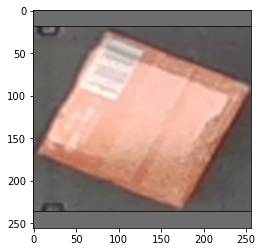

In [39]:
train_df = load_data('TRAIN')
loader = LoadData('TRAIN')
plt.imshow(loader[0][0].astype('int64'))


In [40]:
model_b7 = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling='max',
    classes=1000,
    classifier_activation="softmax")


In [6]:
embb7 = np.zeros((len(train_df), 2560))
for i in range(len(train_df)):
    embb7[i] = model_b7(loader[i])[0]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.000s...
[t-SNE] Computed neighbors for 144 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 25.140057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.643677
[t-SNE] KL divergence after 1000 iterations: 0.311833


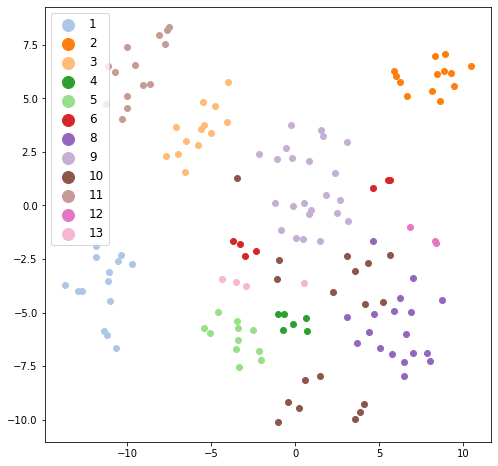

In [646]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(embb7)
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 8))
num_categories = 12
for lab in range(1, num_categories+2):
    if lab == 7:
        pass
    else:
        # Przy uruchomieniu zrobić zamiast df train_df lub val_df
        indices = np.asarray(df['y']) == lab
        ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], c=np.array(
            cmap(lab)).reshape(1, 4), label=lab, alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()


In [51]:
val_gen = LoadData('VAL')
print(val_gen.batch_return)




<bound method LoadData.batch_return of <__main__.LoadData object at 0x0000015B35CEC610>>


In [57]:
results = []
val_df = load_data('VAL')
val_gen = LoadData('VAL')


batch_size = 128
print(len(val_df)//batch_size + 1)
for i in range(len(val_df)//batch_size +  1):
    print(float(i)/(len(val_df)//batch_size + 1))
    temp_arr = np.zeros((batch_size, 256, 256, 3))
    for j in range(batch_size):
        temp_idx = i*batch_size + j
        temp_arr[j] = val_gen[temp_idx]

    r_tmp = model_b7(temp_arr)[0]
    


IndexError: index 4 is out of bounds for axis 0 with size 4

In [649]:
from scipy.spatial import distance
import numpy as np

MAX_CLASS = 13  # maksymalne id klasy


def compute_distances(x, embedding, method=distance.cosine):
    distances = np.zeros((embedding.shape[0]))
    for i in range(embedding.shape[0]):
        distances[i] = method(embedding[i], x)
    return distances


In [650]:
distances = []

for i in range(len(results)):
    if results[i] is not np.NaN:
        distances.append(compute_distances(results[i], embb7))
    else:
        distances.append(np.NaN)


In [651]:
distances_df = pd.DataFrame(columns=range(144))

for i in range(len(distances)):
    if distances[i] is not np.NaN:
        a = pd.DataFrame(distances[i]).T
        distances_df = distances_df.append(a, ignore_index=True)
    else:
        distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)


/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed

/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(a, ignore_index=True)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)
/var/folders/wx/h94qdtjs0fv1m8pj6fchk8m00000gn/T/ipykernel_24435/3879347528.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

In [652]:
distances_df.dropna(how='any')


,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.297605,0.273275,0.298023,0.353833,0.331846,0.348816,0.311005,0.312362,0.304573,0.331491,...,0.345945,0.293975,0.286427,0.307655,0.283311,0.249532,0.358216,0.351063,0.353424,0.347892
5,0.284702,0.253132,0.293394,0.309416,0.253086,0.319097,0.289859,0.303155,0.272934,0.295675,...,0.308122,0.232221,0.306668,0.285873,0.248627,0.230018,0.328003,0.319932,0.311573,0.311762
10,0.196194,0.120981,0.116604,0.152212,0.184855,0.193686,0.109889,0.232008,0.195586,0.252153,...,0.30397,0.208696,0.238718,0.277528,0.244574,0.219443,0.329637,0.317994,0.313616,0.231479
20,0.334015,0.303169,0.274351,0.35964,0.3611,0.36342,0.3055,0.344986,0.338184,0.357018,...,0.39797,0.329127,0.302684,0.338436,0.327445,0.292412,0.400046,0.382358,0.388924,0.363006
23,0.251475,0.168164,0.122199,0.175694,0.209849,0.229036,0.126038,0.237378,0.235765,0.286879,...,0.309868,0.211216,0.282281,0.270871,0.24402,0.224853,0.332919,0.326219,0.32166,0.244721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6585,0.222079,0.190148,0.255329,0.210435,0.200152,0.234255,0.215545,0.216315,0.130798,0.165891,...,0.202857,0.125842,0.198956,0.199311,0.164056,0.134825,0.264561,0.281113,0.236131,0.175777
6586,0.212808,0.187586,0.253172,0.206215,0.18997,0.2275,0.221211,0.202705,0.123464,0.146967,...,0.195254,0.104206,0.202715,0.205407,0.16474,0.140664,0.259957,0.275619,0.238123,0.169824
6587,0.207564,0.173301,0.233991,0.228296,0.200468,0.221734,0.21638,0.205528,0.137777,0.17134,...,0.209963,0.138506,0.172932,0.178209,0.146901,0.112174,0.24512,0.253789,0.227431,0.180807
6588,0.21228,0.187445,0.248311,0.242011,0.212222,0.235313,0.229663,0.212412,0.147291,0.168012,...,0.215018,0.151131,0.187128,0.193971,0.166742,0.132584,0.255902,0.266528,0.242768,0.195119


In [653]:
distances_df.dropna(how='any').to_csv('distances_df')


In [654]:
def classify(distances, classes):
    '''
    same lengths
    distances - np.array
    classes - np.array
    returns: class
    '''
    weights = {cls: [] for cls in classes}
    for i in range(len(distances)):
        weights[classes[i]].append(distances[i])

    m = max(sum(list(map(lambda x: pow(x, -1), scores)))/len(scores)
            for scores in weights.values())
    for cls in weights.keys():
        lm = sum(
            list(map(lambda x: pow(x, -1), weights[cls])))/len(weights[cls])
        if lm == m:
            return cls


'''
distances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]
classes =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']
print('max: ', classify(distances, classes))
'''


"\ndistances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]\nclasses =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']\nprint('max: ', classify(distances, classes))\n"

In [655]:
predictions = []


for i in range(len(distances)):
    if distances[i] is not np.NaN:
        predictions.append(classify(distances[i], train_df['y']))
    else:
        predictions.append(np.NaN)


In [656]:
results_df = pd.DataFrame()
results_df['preds'] = predictions
results_df['y'] = val_df['y']


In [657]:
off_res = results_df.dropna(how='any')


In [658]:
off_res = off_res.drop(off_res.loc[off_res['y'] == 7].index)
off_res = off_res.drop(off_res.loc[off_res['y'] > 13].index)


In [659]:
(off_res['preds'] == off_res['y']).sum()/(len(off_res))


0.7773695811903012

In [597]:
off_res


,preds,y
0,4.0,4
5,4.0,4
10,5.0,8
20,4.0,4
23,8.0,8
...,...,...
6585,9.0,9
6586,9.0,9
6587,9.0,9
6588,9.0,9


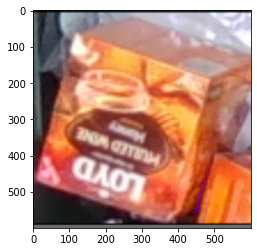

In [599]:
plt.imshow(val_gen[10][0].astype('int64'))


In [378]:
labs = train_df['y'].unique()
labs.sort()
labs


array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13])

In [391]:
off_res.loc[off_res['y'] == 6]


,preds,y
461,5.0,6
901,4.0,6
926,6.0,6
1722,4.0,6
2002,4.0,6
2501,4.0,6
2522,4.0,6
3576,6.0,6
3580,6.0,6
3605,6.0,6


In [369]:
off_res.loc[off_res['preds'] != off_res['y']].head(10)


,preds,y
23,4.0,8
28,4.0,8
36,4.0,8
38,4.0,9
39,4.0,8
43,4.0,8
48,4.0,9
50,4.0,8
51,8.0,9
65,4.0,8


In [388]:
deps = np.zeros((14, 14))

for i in range(len(off_res)):
    deps[int(off_res.iloc[i]['preds']), int(off_res.iloc[i]['y'])] += 1


In [665]:
acc_by_class = np.zeros((14))

for i in range(14):
    if i != 0 and i != 7:
        acc_by_class[i] = len(off_res.loc[(off_res['y'] == i) & (
            off_res['preds'] == i)])/len(off_res.loc[(off_res['y'] == i)])


In [668]:
acc_by_class


array([0.        , 0.82312925, 0.97826087, 0.94945848, 0.83333333,
       0.6031746 , 0.41666667, 0.        , 0.93571429, 0.54761905,
       0.59292035, 0.63255814, 0.8       , 1.        ])

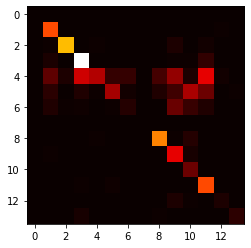

In [389]:
plt.imshow(deps, cmap='hot')


bad_class4 = embb7[train_df.loc[train_df['y']==4].index]

import tensorflow as tf
from tensorflow import keras
import numpy as np
from scipy.spatial import distance


def myLossFunction(sample):
    distances = []
    bad_class = bad_class4
    for bad_samp in bad_class:
        dist = distance.cosine(sample, bad_samp)
        distances.append(dist)

    return 1/np.mean(distances)

myLossFunctionVec = np.vectorize(myLossFunction)

class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        sample_weight = None
        x = data

        with tf.GradientTape() as tape:
            # y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = myLossFunctionVec(x)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct and compile an instance of CustomModel
model = CustomModel(model_b7)
model.compile(optimizer="adam")